# Kaggle Tutorial : Red wine quality prediction

This notebook contains the **Multi Layer Perceptron (MLP)** model for predicting red wine quality with the `red-wine.csv` kaggle dataset. The model is defined and trained using TensorFlow and Pytorch Frameworks.


In [1]:
# imports
import pandas as pd

Load red-wine dataset from `red-wine.csv`file.

In [2]:
# Load data set
df = pd.read_csv('red-wine.csv')
print("Dimensions of dataset:",df.shape)
df.head()

Dimensions of dataset: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


`quality` is the prediction target. Other columns are the input to the model. 

Create training and validation splits.

In [3]:
df_train = df.sample(frac=0.7, random_state=0)
df_test = df.drop(df_train.index)

# Split the data into input(X) and target(y) variables
X_train = df_train.drop('quality', axis=1)
X_test = df_test.drop('quality', axis=1)
y_train = df_train['quality']
y_test = df_test['quality']

input_shape = X_train.shape[1]
X_train.shape

(1119, 11)

## Tensor Flow solution

The following model definition is based on Deep Learning [tutorial](https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization) in kaggle.

Define the `Sequential` model with `Dense` 

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

tf_model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

2024-06-11 18:58:49.835992: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 18:58:50.055355: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 18:58:50.055409: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 18:58:50.055447: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-11 18:58:50.095225: I tensorflow/core/platform/cpu_feature_g

Compile the model with `adam` optimizer and `mse` mean square loss. Train the model by calling `model.fit` function specifying `epochs=100` and `batch_size=250`.

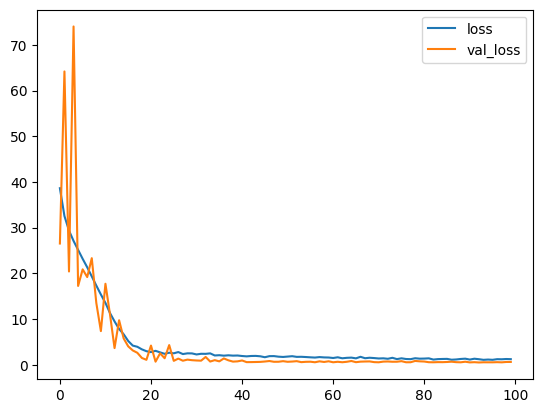

In [ ]:
# Compile and train the model
tf_model.compile(
    optimizer='adam',
    loss='mse',
)

history = tf_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=100,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

# Kaggle Tutorial : PyTorch

Recreate the same tensorflow model using PyTorch. The aim of this exercise is to learn building of Deep Learning model and training using PyTorch framework.

In [15]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

Define the Regressor model with drop outs, batch normalization layers and compile it with early stopping.

In [16]:
# Define the model
class RedWineRegressor(nn.Module):
    def __init__(self):
        super(RedWineRegressor, self).__init__()
        self.linear1 = nn.Linear(input_shape, 1024)
        self.Dropout1 = nn.Dropout(p=0.3)
        self.BatchNorm1 = nn.BatchNorm1d(1024)
        self.linear2 = nn.Linear(1024, 1024)
        self.Dropout2 = nn.Dropout(p=0.3)
        self.BatchNorm2 = nn.BatchNorm1d(1024)
        self.linear3 = nn.Linear(1024, 1024)
        self.Dropout3 = nn.Dropout(p=0.3)
        self.BatchNorm3 = nn.BatchNorm1d(1024)
        self.linear4 = nn.Linear(1024, 1)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.Dropout1(x)
        x = self.BatchNorm1(x)
        x = F.relu(self.linear2(x))
        x = self.Dropout2(x)
        x = self.BatchNorm2(x)
        x = F.relu(self.linear3(x))
        x = self.Dropout3(x)
        x = self.BatchNorm3(x)
        x = self.linear4(x)
        return x

pt_model = RedWineRegressor()

Define loss function and optimizer

In [17]:
# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(pt_model.parameters(), lr=0.01)

Define DataSet class and DataLoder for batch processing of data during training.

In [18]:
# Define class for RedWine Dataset 
class RedWineDataset(torch.utils.data.Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        return self.data[idx,:], self.target[idx]

BATCH_SIZE=256
# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_test.values, dtype=torch.float32)
# Create dataset objects for train and validation sets
train_dataset = RedWineDataset(X_train_tensor, y_train_tensor)
valid_dataset = RedWineDataset(X_valid_tensor, y_valid_tensor)

# Create dataloaders with train and validation sets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

In PyTorch the steps involved in training each epoch needs to be manually defined as a function. Then the Create a Training Loop that calls epoch training function in a loop for number of epochs defined. 

Calculate training and validation losses for each epoch. Additionaly implement **early stopping** strategy to avoid overfitting and underfitting of the model.

In [19]:
# Define training epoch
def train_epoch(model, trainloader, criterion, optimizer):
    running_loss= 0.0
    epoch_loss = 0.0

    for i, data in enumerate(trainloader):
        inputs, targets = data
        # Zero your gradients for each batch!
        optimizer.zero_grad()
        # forward pass
        outputs = model(inputs)
        
        # calculate loss
        loss = criterion(outputs, targets)
        # backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        # Gather data on running loss
        running_loss += loss.item()
        # Loss per batch
    
    epoch_loss = running_loss / (i+1)
    
    return epoch_loss

# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.prev_loss = 0

    # def __call__(self, train_loss, validation_loss):
    #     if abs(validation_loss - train_loss) > self.min_delta:
    #         self.counter +=1
    #         print("EarlyStopping Counter:", self.counter)
    #         if self.counter >= self.tolerance:  
    #             self.early_stop = True

    def __call__(self,valid_loss):
        print(self.counter, self.prev_loss, valid_loss)
        if abs(valid_loss - self.prev_loss) < self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
        else:
            self.counter = 0
        
        # update the prev_loss to the current validation loss
        self.prev_loss = valid_loss

Training Loop

In [20]:
# Model training
EPOCHS = 100
best_vloss = 1_000_000.
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

for epoch in range(EPOCHS):
    # Set the model in training mode
    pt_model.train()
    # Calculate training loss
    train_loss = train_epoch(pt_model,trainloader,criterion,optimizer)
    
    # Compute validation loss
    running_vloss = 0.0
    # Set model in evaluation mode
    pt_model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validloader):
            vinputs, vtargets = vdata
            voutputs = pt_model(vinputs)
            vloss = criterion(voutputs, vtargets)
            valid_loss = vloss.item()
            running_vloss += valid_loss
    valid_loss = running_vloss / (i+1)
    
    print(f'Epoch {epoch+1}/{EPOCHS} Training Loss: {train_loss:.4f} Validation Loss: {valid_loss:.4f}')

    # early stopping
    # early_stopping(train_loss, valid_loss)
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print("We are at epoch:", epoch)
        break

    # #  take best preformance and save model's state
    # if last_vloss < best_vloss:
    #     best_vloss = last_vloss
    #     model_path = f"red-wine_model_epoch_{epoch+1}_vloss_{last_vloss:.4f}"
    #     torch.save(pt_model.state_dict(), model_path)

Epoch 1/100 Training Loss: 15.7515 Validation Loss: 1.3876
0 0 1.3876462777455647
Epoch 2/100 Training Loss: 1.6819 Validation Loss: 0.9435
0 1.3876462777455647 0.9434550444285075
Epoch 3/100 Training Loss: 1.3019 Validation Loss: 0.7081
0 0.9434550444285075 0.7081324100494385
Epoch 4/100 Training Loss: 1.2102 Validation Loss: 0.7631
0 0.7081324100494385 0.7630547444025676
Epoch 5/100 Training Loss: 1.1814 Validation Loss: 0.6952
0 0.7630547444025676 0.6951993922392528
Epoch 6/100 Training Loss: 1.0285 Validation Loss: 0.6821
0 0.6951993922392528 0.6820539931456248
Epoch 7/100 Training Loss: 1.0112 Validation Loss: 0.7405
0 0.6820539931456248 0.7405288656552632
Epoch 8/100 Training Loss: 1.0015 Validation Loss: 0.7286
0 0.7405288656552632 0.7286012947559357
Epoch 9/100 Training Loss: 0.9901 Validation Loss: 0.7742
0 0.7286012947559357 0.774170458316803
Epoch 10/100 Training Loss: 0.9405 Validation Loss: 0.8992
0 0.774170458316803 0.8991937279701233
Epoch 11/100 Training Loss: 0.9522 Va